In [5]:
import numpy as np
from numpy.random import Generator, PCG64
import matplotlib.pyplot as plt
import math
import time
from heateq import Exact, Simulateur
import tqdm

In [6]:
seed = 213731490053398181466621250222036675538
rng = Generator(PCG64(seed))

In [7]:
# Simulateurs haute et basse fidélité
f = Simulateur(21, 100)
g = Simulateur(3, 20)

In [8]:
# Espérance exacte de la solution continue
mu_exact = Exact().mu
print(mu_exact)

# Espérance exacte de Y = f(X) (solution discrétisée, haute fidélité)
mu_Y_exact = f.mu
print(mu_Y_exact)

# Espérance exacte de Z = g(X) (solution discrétisée, basse fidélité)
mu_Z_exact = g.mu
print(mu_Z_exact)

41.98447216482205
41.91646529470801
33.036172063443146


In [9]:
w = 1/35

In [10]:
# Permet d'obtenir un n-échnatillon du vecteur aléatoir d'entrée X
def n_echantillon_X(n):
    return np.vstack(
        (
            rng.uniform(-math.pi, math.pi, (3, n)),
            rng.uniform(0.001, 0.009, (1, n)), 
            rng.uniform(-1., 1., (3, n))
        )
    )

# Espérance $\mu_Z$ connue

On considère $\mu_Z$ connue. Elle est donnée par la variable `mu_Z_exact`.

## Paramètre optimal $\alpha^*$ indépendant (précalculé)
Utiliser la valeur de $\alpha^*$ estimée précédemment pour contruire un estimateur par variable de contrôle pour l'espérance de $Y$. Faire `nr = 1000` répétitions pour des budgets $\tilde{n} \in \{10; 20; 50; 100; 200; 500; 1000; 2000; 5000; 10000\}$.

Estimer la réduction de variance à budget équivalent entre l'estimateur par variable de contrôle et l'estimateur Monte Carlo classique (haute fidélité). Est-elle conforme à la valeur de $\beta$ calculée précédemment ?

Tracer l'espérance et l'écart-type des estimateurs par variable de contrôle et Monte Carlo (haute fidélité) à budget équivalent en fonction de $\tilde{n}$. Sur un autre graphe, tracer l'évolution de l'écart-type des estimateurs en fonction de $\tilde{n}$.

In [7]:
# Define the budgets
nr = 1000
budgets = [10, 20, 50, 100, 200, 500, 1000]

# Initialize lists to store the means and standard deviations
mean_control_variate = []
std_control_variate = []
mean_monte_carlo = []
std_monte_carlo = []
REQM_list=[]
REQM_list_mc =[]

X_alpha = n_echantillon_X(1000)
Y_alpha = f(X_alpha)
Z_alpha = g(X_alpha)
cov_alpha = np.cov(Y_alpha, Z_alpha)
alpha = cov_alpha[0, 1] / cov_alpha[1, 1]

# Perform nr repetitions for each budget
for budget in tqdm.tqdm(budgets):
    # Initialize lists to store the estimates
    estimates_control_variate = []
    estimates_monte_carlo = []
    REQM_list_temp = []
    REQM_list_temp_mc = []

    for _ in range(nr):
        # Generate samples of X
        X = n_echantillon_X(budget)
        # Generate samples of Y = f(X)
        Y = f(X)
        # Generate samples of Z = g(X)
        Z = g(X)
        
        # Compute the estimate using the control variate method
        estimate_control_variate = np.mean(Y - alpha * (Z - mu_Z_exact))
        estimate_monte_carlo = np.mean(Y)

        # Append the estimates to the lists
        REQM_list_temp.append(np.sqrt((estimate_control_variate - mu_Y_exact)**2))
        REQM_list_temp_mc.append(np.sqrt((estimate_monte_carlo - mu_Y_exact)**2))
        estimates_control_variate.append(estimate_control_variate)
        estimates_monte_carlo.append(estimate_monte_carlo)
    
    # Compute the mean and standard deviation of the estimates for each budget
    mean_control_variate.append(np.mean(estimates_control_variate))
    std_control_variate.append(np.std(estimates_control_variate))
    mean_monte_carlo.append(np.mean(estimates_monte_carlo))
    std_monte_carlo.append(np.std(estimates_monte_carlo))
    REQM_list.append(np.mean(REQM_list_temp))
    REQM_list_mc.append(np.mean(REQM_list_temp_mc))

100%|██████████| 7/7 [01:26<00:00, 12.32s/it]


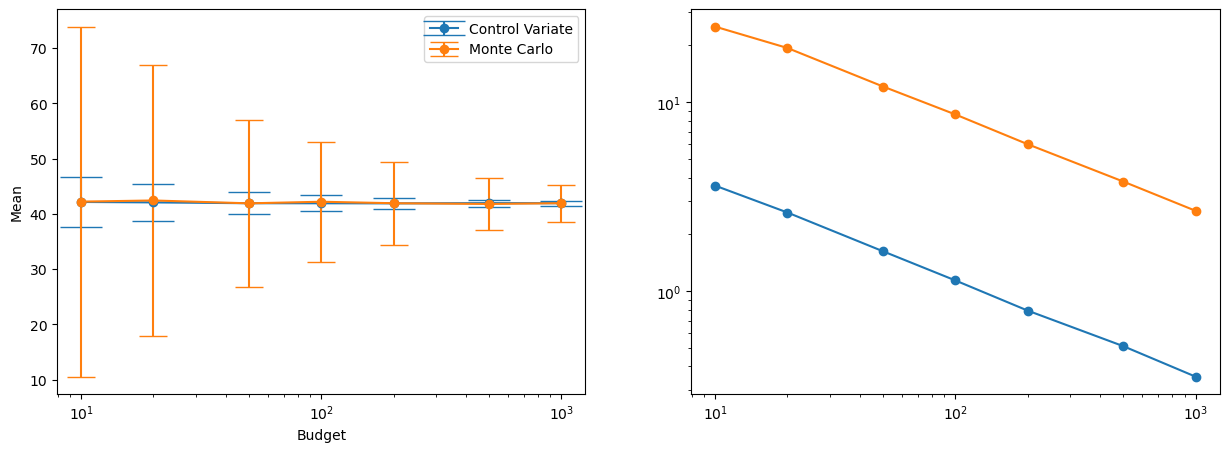

In [8]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.errorbar(budgets, mean_control_variate, yerr=std_control_variate, label='Control Variate', marker='o',capsize=15)
plt.errorbar(budgets, mean_monte_carlo, yerr=std_monte_carlo, label='Monte Carlo', marker='o',capsize=10)
plt.xlabel("Nombre d'échantillon")
plt.xscale('log')
plt.ylabel('Mean')
plt.legend()
plt.subplot(1, 2, 2)
plt.loglog(budgets, REQM_list, marker="o", label='Control Variate')
plt.loglog(budgets, REQM_list_mc, marker="o", label='Monte Carlo')
plt.legend()
plt.show()

## Paramètre optimal $\alpha^*$ estimé à la volée
Renouveler l'expérience avec $\alpha^*$ estimé avec les échantillons disponibles pour l'estimation par variable de contrôle.

Tracer les mêmes graphes que précédemment. L'estimation de $\alpha^*$ à la volée induit-elle un biais et/ou une dégradation de la réduction de variance ?

In [9]:
# Define the budgets
nr = 1000
budgets = [10, 20, 50, 100, 200, 500, 1000]

# Initialize lists to store the means and standard deviations
mean_control_variate_volee = []
std_control_variate_volee = []
mean_monte_carlo_volee = []
std_monte_carlo_volee = []
REQM_list_volee=[]
REQM_list_mc_volee=[]

# X_alpha = n_echantillon_X(1000)
# Y_alpha = f(X_alpha)
# Z_alpha = g(X_alpha)
# cov_alpha = np.cov(Y_alpha, Z_alpha)
# alpha = cov_alpha[0, 1] / cov_alpha[1, 1]

# Perform nr repetitions for each budget
for budget in tqdm.tqdm(budgets):
    # Initialize lists to store the estimates
    estimates_control_variate = []
    estimates_monte_carlo = []
    REQM_list_temp = []
    REQM_list_temp_mc = []
    
    for _ in range(nr):
        # Generate samples of X
        X = n_echantillon_X(budget)
        # Generate samples of Y = f(X)
        Y = f(X)
        # Generate samples of Z = g(X)
        Z = g(X)

        cov_alpha = np.cov(Y, Z)
        alpha = cov_alpha[0, 1] / cov_alpha[1, 1]
        
        # Compute the estimate using the control variate method
        estimate_control_variate = np.mean(Y - alpha * (Z - mu_Z_exact))
        estimate_monte_carlo = np.mean(Y)
        

        # Append the estimates to the lists
        REQM_list_temp.append(np.sqrt((estimate_control_variate - mu_Y_exact)**2))
        REQM_list_temp_mc.append(np.sqrt((estimate_monte_carlo - mu_Y_exact)**2))
        estimates_control_variate.append(estimate_control_variate)
        estimates_monte_carlo.append(estimate_monte_carlo)
    
    # Compute the mean and standard deviation of the estimates for each budget
    mean_control_variate_volee.append(np.mean(estimates_control_variate))
    std_control_variate_volee.append(np.std(estimates_control_variate))
    mean_monte_carlo_volee.append(np.mean(estimates_monte_carlo))
    std_monte_carlo_volee.append(np.std(estimates_monte_carlo))
    REQM_list_volee.append(np.mean(REQM_list_temp))
    REQM_list_mc_volee.append(np.mean(REQM_list_temp_mc))

100%|██████████| 7/7 [01:17<00:00, 11.06s/it]


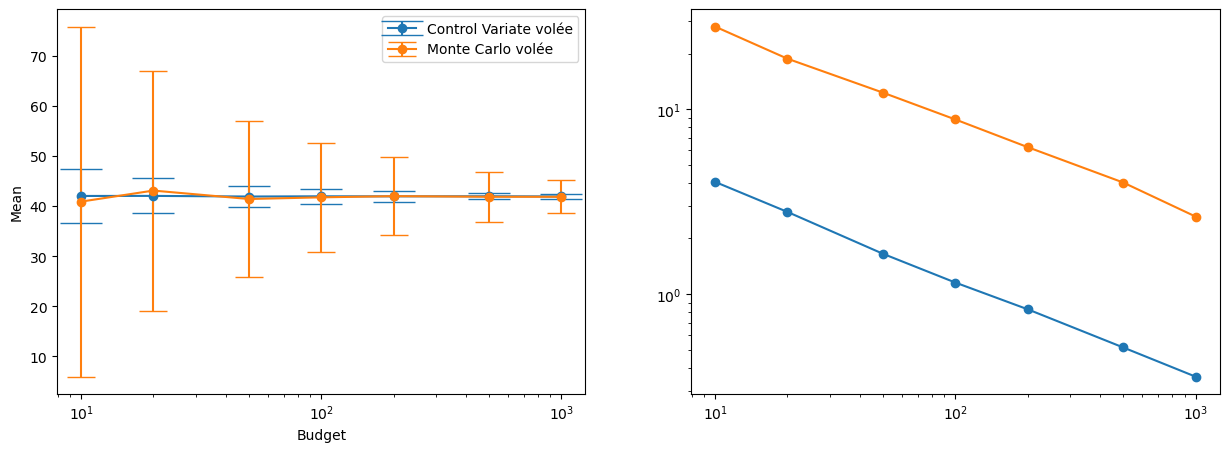

In [10]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.errorbar(budgets, mean_control_variate_volee, yerr=std_control_variate_volee, label='Control Variate volée', marker='o',capsize=15)
plt.errorbar(budgets, mean_monte_carlo_volee, yerr=std_monte_carlo_volee, label='Monte Carlo volée', marker='o',capsize=10)
plt.xlabel("Nombre d'échantillon")
plt.xscale('log')
plt.ylabel('Mean')
plt.legend()
plt.subplot(1, 2, 2)
plt.loglog(budgets, REQM_list_volee, marker="o", label='Control Variate volée')
plt.loglog(budgets, REQM_list_mc_volee, marker="o", label='Monte Carlo volée')
plt.legend()
plt.show()

## Métamodèle

Mêmes questions en utilisant un métamodèle comme simulateur basse fidélité.
Voir, par exemple, https://openturns.github.io/openturns/latest/auto_meta_modeling/kriging_metamodel/plot_kriging.html

In [11]:
import openturns as ot

In [12]:
# pour faciliter l'évaluation de la même manière que nos simulateurs
class ScalarModel_from_ot:
    def __init__(self, ot_model):
        self.ot_model = ot_model

    def __call__(self, xi):
        return np.array(self.ot_model(xi.T))[:,0]

In [13]:
n_doe = 1000
X_doe = n_echantillon_X(n_doe)
Y_doe = f(X_doe)
dimension = X_doe.shape[0]

In [14]:
basis = ot.ConstantBasisFactory(dimension).build()
covarianceModel = ot.MaternModel([1.0] * dimension, 1.5)
algo = ot.KrigingAlgorithm(X_doe.T, Y_doe[:,None], covarianceModel, basis) # conversion to OpenTurns data structure
algo.run()
res = algo.getResult()
g_mm = ScalarModel_from_ot( res.getMetaModel() )

WRN - Warning! For coherency we set scale upper bounds = [12.5422,12.5623,12.5314,0.0159802,3.97645,3.99158,3.99688]
WRN - Starting point is not inside bounds x=[1,1,1,1,1,1,1] bounds=class=Interval name=Unnamed dimension=7 lower bound=class=Point name=Unnamed dimension=7 values=[0.01,0.01,0.01,0.01,0.01,0.01,0.01] upper bound=class=Point name=Unnamed dimension=7 values=[12.5422,12.5623,12.5314,0.0159802,3.97645,3.99158,3.99688] finite lower bound=[1,1,1,1,1,1,1] finite upper bound=[1,1,1,1,1,1,1]


In [15]:
X_gmm = n_echantillon_X(int(1e6))
mu_Z_gmm = np.mean(g_mm(X_gmm))

In [23]:
# Define the budgets
nr = 1000
budgets = [10, 20, 50, 100, 200, 500, 1000]

# Initialize lists to store the means and standard deviations
mean_control_variate_mm = []
std_control_variate_mm = []
mean_monte_carlo_mm = []
std_monte_carlo_mm = []
REQM_list_mm=[]
REQM_list_mc_mm=[]

X_alpha = n_echantillon_X(1000)
Y_alpha = f(X_alpha)
Z_alpha = g(X_alpha)
cov_alpha = np.cov(Y_alpha, Z_alpha)
alpha = cov_alpha[0, 1] / cov_alpha[1, 1]

# Perform nr repetitions for each budget
for budget in tqdm.tqdm(budgets):
    # Initialize lists to store the estimates
    estimates_control_variate = []
    estimates_monte_carlo = []
    REQM_list_temp = []
    REQM_list_temp_mc = [] are going to create an approximation of a model response using a kriging model. We consider a bidimensional function with gaussian inputs. Th
    
    for _ in range(nr):
        # Generate samples of X
        X = n_echantillon_X(budget)
        # Generate samples of Y = f(X)
        Y = f(X)
        # Generate samples of Z = g(X)
        Z = g_mm(X)
        
        # Compute the estimate using the control variate method
        estimate_control_variate = np.mean(Y - alpha * (Z - mu_Z_gmm))
        estimate_monte_carlo = np.mean(Y)        

        # Append the estimates to the lists
        REQM_list_temp.append(np.sqrt((estimate_control_variate - mu_Y_exact)**2))
        REQM_list_temp_mc.append(np.sqrt((estimate_monte_carlo - mu_Y_exact)**2))
        estimates_control_variate.append(estimate_control_variate)
        estimates_monte_carlo.append(estimate_monte_carlo)
    
    # Compute the mean and standard deviation of the estimates for each budget
    mean_control_variate_mm.append(np.mean(estimates_control_variate))
    std_control_variate_mm.append(np.std(estimates_control_variate))
    mean_monte_carlo_mm.append(np.mean(estimates_monte_carlo))
    std_monte_carlo_mm.append(np.std(estimates_monte_carlo))
    REQM_list_mm.append(np.mean(REQM_list_temp))
    REQM_list_mc_mm.append(np.mean(REQM_list_temp_mc))

100%|██████████| 7/7 [00:56<00:00,  8.04s/it]


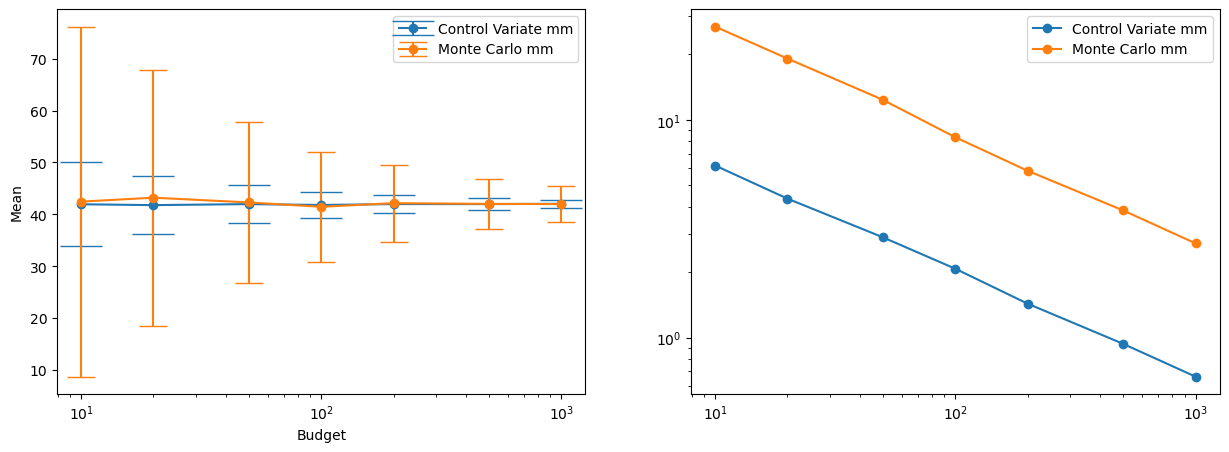

In [17]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.errorbar(budgets, mean_control_variate_mm, yerr=std_control_variate_mm, label='Control Variate mm', marker='o',capsize=15)
plt.errorbar(budgets, mean_monte_carlo_mm, yerr=std_monte_carlo_mm, label='Monte Carlo mm', marker='o',capsize=10)
plt.xlabel('Budget')
plt.xscale('log')
plt.ylabel('Mean')
plt.legend()
plt.subplot(1, 2, 2)
plt.loglog(budgets, REQM_list_mm, marker="o", label='Control Variate mm')
plt.loglog(budgets, REQM_list_mc_mm, marker="o", label='Monte Carlo mm')
plt.legend()
plt.show()

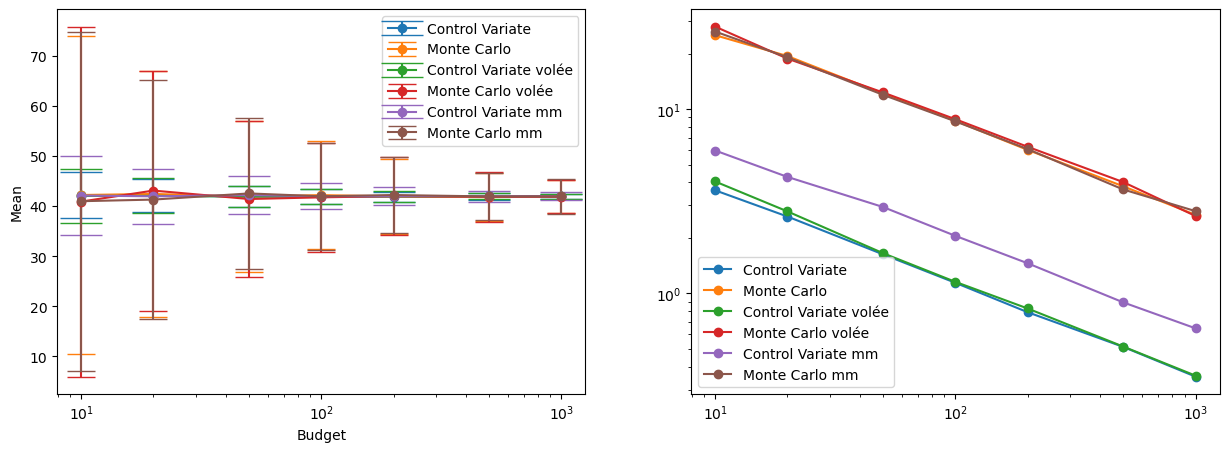

In [24]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.errorbar(budgets, mean_control_variate, yerr=std_control_variate, label='Control Variate', marker='o',capsize=15)
plt.errorbar(budgets, mean_monte_carlo, yerr=std_monte_carlo, label='Monte Carlo', marker='o',capsize=10)
plt.errorbar(budgets, mean_control_variate_volee, yerr=std_control_variate_volee, label='Control Variate volée', marker='o',capsize=15)
plt.errorbar(budgets, mean_monte_carlo_volee, yerr=std_monte_carlo_volee, label='Monte Carlo volée', marker='o',capsize=10)
plt.errorbar(budgets, mean_control_variate_mm, yerr=std_control_variate_mm, label='Control Variate mm', marker='o',capsize=15)
plt.errorbar(budgets, mean_monte_carlo_mm, yerr=std_monte_carlo_mm, label='Monte Carlo mm', marker='o',capsize=10)
plt.xlabel('Budget')
plt.xscale('log')
plt.ylabel('Mean')
plt.legend()
plt.subplot(1, 2, 2)
plt.loglog(budgets, REQM_list, marker="o", label='Control Variate')
plt.loglog(budgets, REQM_list_mc, marker="o", label='Monte Carlo')
plt.loglog(budgets, REQM_list_volee, marker="o", label='Control Variate volée')
plt.loglog(budgets, REQM_list_mc_volee, marker="o", label='Monte Carlo volée')
plt.loglog(budgets, REQM_list_mm, marker="o", label='Control Variate mm')
plt.loglog(budgets, REQM_list_mc_mm, marker="o", label='Monte Carlo mm')
plt.legend()
plt.show()

## Plusieurs variables de contrôle

Combiner plusieurs simulateurs basse fidélité (supposer $\mu_Z$ connue), et estimer $R^2$.

In [19]:
g2 = Simulateur(1, 10)
mu_g2_exact = g2.mu

In [20]:
# Define the budgets
nr = 1000
budgets = [10, 20, 50, 100, 200, 500, 1000]

# Initialize lists to store the means and standard deviations
mean_control_variate_mv = []
std_control_variate_mv = []
mean_monte_carlo_mv = []
std_monte_carlo_mv = []
REQM_list_mv=[]
REQM_list_mc_mv=[]

X_alpha = n_echantillon_X(1000)
Y_alpha = f(X_alpha)
Z_alpha = g(X_alpha)
cov_alpha = np.cov(Y_alpha, Z_alpha)
alpha = cov_alpha[0, 1] / cov_alpha[1, 1]

# Perform nr repetitions for each budget
for budget in tqdm.tqdm(budgets):
    # Initialize lists to store the estimates
    estimates_control_variate = []
    estimates_monte_carlo = []
    REQM_list_temp = []
    REQM_list_temp_mc = []
    
    for _ in range(nr):
        # Generate samples of X
        X = n_echantillon_X(budget)
        # Generate samples of Y = f(X)
        Y = f(X)
        # Generate samples of Z = g(X)
        Z1 = g(X)
        Z2 = g2(X)
        Z3 = g_mm(X)
        
        # Compute the estimate using the control variate method
        estimate_control_variate = np.mean(Y - alpha * (Z - mu_Z_gmm))
        estimate_monte_carlo = np.mean(Y)        

        # Append the estimates to the lists
        REQM_list_temp.append(np.sqrt((estimate_control_variate - mu_Y_exact)**2))
        REQM_list_temp_mc.append(np.sqrt((estimate_monte_carlo - mu_Y_exact)**2))
        estimates_control_variate.append(estimate_control_variate)
        estimates_monte_carlo.append(estimate_monte_carlo)
    
    # Compute the mean and standard deviation of the estimates for each budget
    mean_control_variate_mv.append(np.mean(estimates_control_variate))
    std_control_variate_mv.append(np.std(estimates_control_variate))
    mean_monte_carlo_mv.append(np.mean(estimates_monte_carlo))
    std_monte_carlo_mv.append(np.std(estimates_monte_carlo))
    REQM_list_mv.append(np.mean(REQM_list_temp))
    REQM_list_mc_mv.append(np.mean(REQM_list_temp_mc))

  0%|          | 0/7 [00:00<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (10,) (1000,) 

# Optionnel

## Leave-one-out

Coder l'estimateur par variable de contrôle avec leave-one-out ($\mu_Z$ connue).